In [ ]:
import os

url_path = "https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/rnn"
downloads = {"surnames_with_splits.csv": None,
             "nlp.py": None}

for download_name, extract_name in downloads.items():
    if extract_name and os.path.exists(extract_name):
        continue

    if not os.path.exists(download_name):
        import requests
        response = requests.get(f"{url_path}{download_name}")
        with open(download_name, "wb") as fp:
            fp.write(response.content)
        response.close()

    if not extract_name:
        continue

    _, ext = os.path.splitext(download_name)
    if ext == ".bz2":    
        import bz2
        with open(download_name, 'rb') as bzf, open(extract_name, 'wb') as fp:
            fp.write(bz2.decompress(bzf.read()))
    elif ext == ".zip":
        from zipfile import ZipFile
        with ZipFile(download_name) as zf:
            zf.extractall(path=".")


# SOLUTION: Classifying Surnames with a RNN

## Imports

In [3]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

from nlp import Vocabulary, StepByStep, allclose, mdprint

# 1 Data preparation

This code reads a CSV file named `"surnames_with_splits.csv"` into a DataFrame using pandas. It then splits the DataFrame into three subsets based on the value in the `split` column: 

- `train_df`: Contains rows where the `split` column equals `"train"`.
- `val_df`: Contains rows where the `split` column equals `"val"`.
- `test_df`: Contains rows where the `split` column equals `"test"`.

Finally, it displays the `train_df` DataFrame, which contains the training data.

In [4]:
surname_df = pd.read_csv("surnames_with_splits.csv")

train_df = surname_df[surname_df.split == "train"]
val_df = surname_df[surname_df.split == "val"]
test_df = surname_df[surname_df.split == "test"]

train_df


,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train
...,...,...,...
10957,Chu,Vietnamese,train
10958,Pham,Vietnamese,train
10959,Chau,Vietnamese,train
10960,Mach,Vietnamese,train


## 1.1 Nationality Counts

👍  
In this task, you need to implement a function called `build_counts` that accepts a sequence (such as a list or array) and returns a dictionary with the count of occurrences for each unique item in the sequence.
- Define the function `build_counts(sequence)` that takes a sequence as input.
- The function should return a dictionary where the keys are the unique items in the sequence, and the values are the counts of each item.

In [5]:
def build_counts(sequence):
    count = {}
    for item in sequence:
        count[item] = count.get(item, 0) + 1
    return count

nationality_counts = build_counts(train_df.nationality)
print(nationality_counts)

assert len(nationality_counts) == 18
assert nationality_counts["English"] == 2080
assert nationality_counts["Portuguese"] == 38

{'Arabic': 1122, 'Chinese': 154, 'Czech': 289, 'Dutch': 165, 'English': 2080, 'French': 160, 'German': 403, 'Greek': 109, 'Irish': 128, 'Italian': 420, 'Japanese': 542, 'Korean': 53, 'Polish': 84, 'Portuguese': 38, 'Russian': 1661, 'Scottish': 52, 'Spanish': 180, 'Vietnamese': 40}


## 1.2 Maximal Size

👍  
In this task, you need to implement a function called `get_max_length` that accepts a sequence (such as a list or array) and returns the length of the longest item in the sequence.
- Define the function `get_max_length(sequence)` that takes a sequence as input.
- The function should return the length of the longest item in the sequence.


In [6]:
def get_max_length(sequence):
    return max(len(item) for item in sequence)

max_surname_size = get_max_length(train_df.surname)
print(max_surname_size)

assert max_surname_size == 17

17


## 1.3 Building Vocabulary

This code initializes two vocabularies, `surname_vocab` and `nationality_vocab`, using a custom `Vocabulary` class.

- `PAD_TOK` is set to a space (`" "`) and `UNK_TOK` is set to an "@" symbol, which are used as special tokens for padding and unknown words, respectively.
- `surname_vocab` is created with these special tokens, and then the vocabulary is populated using the `fill()` method, which is called on the `surname` column from the `train_df` DataFrame.
- `nationality_vocab` is created without any special tokens, and its vocabulary is populated with the unique nationalities from `train_df`, sorted by their frequency (from `nationality_counts`).

Finally, it prints the contents of both `surname_vocab` and `nationality_vocab` to the console.

In [7]:
PAD_TOK = " "
UNK_TOK = "@"

surname_vocab = Vocabulary(pad_tok=PAD_TOK, unk_tok=UNK_TOK)
surname_vocab.fill(train_df.surname)

nationality_vocab = Vocabulary()
nationality_vocab.fill([sorted(set(train_df.nationality), key=nationality_counts.get, reverse=True)])

print(f"Surname vocab: {surname_vocab}")
print(f"Nationality vocab: {nationality_vocab}")

Surname vocab: {' ': 0, '@': 1, 'T': 2, 'o': 3, 't': 4, 'a': 5, 'h': 6, 'A': 7, 'b': 8, 'u': 9, 'd': 10, 'F': 11, 'k': 12, 'r': 13, 'y': 14, 'S': 15, 'e': 16, 'g': 17, 'C': 18, 'm': 19, 'H': 20, 'i': 21, 'K': 22, 'n': 23, 'W': 24, 's': 25, 'f': 26, 'G': 27, 'M': 28, 'l': 29, 'B': 30, 'z': 31, 'N': 32, 'I': 33, 'w': 34, 'D': 35, 'Q': 36, 'j': 37, 'E': 38, 'R': 39, 'Z': 40, 'c': 41, 'Y': 42, 'J': 43, 'L': 44, 'O': 45, '-': 46, 'P': 47, 'X': 48, 'p': 49, ':': 50, 'v': 51, 'U': 52, '1': 53, 'V': 54, 'x': 55, 'q': 56, 'é': 57, 'É': 58, "'": 59, 'ß': 60, 'ö': 61, 'ä': 62, 'ü': 63, 'ú': 64, 'à': 65, 'ò': 66, 'è': 67, 'ó': 68, 'Ś': 69, 'ą': 70, 'ń': 71, 'á': 72, 'ż': 73, 'õ': 74, 'í': 75, 'ñ': 76, 'Á': 77}
Nationality vocab: {'English': 0, 'Russian': 1, 'Arabic': 2, 'Japanese': 3, 'Italian': 4, 'German': 5, 'Czech': 6, 'Spanish': 7, 'Dutch': 8, 'French': 9, 'Chinese': 10, 'Irish': 11, 'Greek': 12, 'Polish': 13, 'Korean': 14, 'Scottish': 15, 'Vietnamese': 16, 'Portuguese': 17}


## 1.4 Nationality Weights

👍  
In this task, you need to implement a function called `build_weights` that calculates weights based on the counts of items and their corresponding indices in a vocabulary.

- Define the function `build_weights(counts, vocab)` that takes two inputs:
  - `counts`: A dictionary containing the counts of each item.
  - `vocab`: A dictionary mapping items to their indices.
- The function should return a tensor of weights, where each weight is calculated as the inverse of the logarithm of the corresponding count.


In [8]:
def build_weights(counts, vocab):
    weights = torch.zeros(len(vocab))
    for item in sorted(counts, key=vocab.get):
        weights[vocab[item]] = counts[item]
    weights = 1 / torch.log(weights)
    return weights

nationality_weights = build_weights(nationality_counts, nationality_vocab)

assert allclose(nationality_weights[:5], [0.1309, 0.1349, 0.1424, 0.1588, 0.1656])
assert nationality_weights.shape == (18,)

## 1.5 Plotting frequencies and weights

This code generates two horizontal bar charts using matplotlib to visualize the frequency and weights of nationalities.

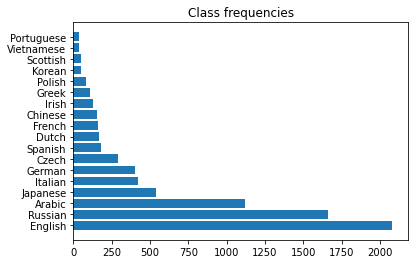

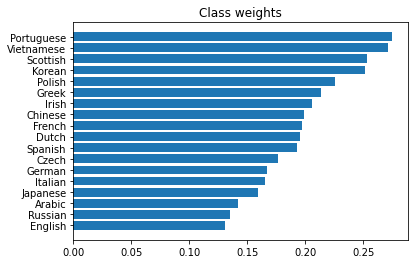

In [9]:
plt.title("Class frequencies")
plt.barh(list(nationality_vocab), [nationality_counts[nation] for nation in nationality_vocab])
plt.show()

plt.title("Class weights")
plt.barh(list(nationality_vocab), nationality_weights)
plt.show()

## 1.6 Surname Vectorization

👍  
In this task, you need to implement a function called `vectorize` that converts a sequence (such as a string) into a fixed-size tensor of integers, based on the provided vocabulary.

- Define the function `vectorize(seq, vocab, max_size)` that takes three inputs:
  - `seq`: A sequence (such as a string) to be vectorized.
  - `vocab`: A dictionary mapping items in the sequence to integer indices.
  - `max_size`: The maximum size of the output tensor.
- The function should return a tensor of size `max_size`, where:
  - Each position in the tensor corresponds to an index from the `vocab` for the corresponding item in the sequence.
  - The sequence is truncated or padded to fit the `max_size`.


In [10]:
def vectorize(seq, vocab, max_size):
    seq = list(seq)[:max_size]
    vec = torch.zeros(max_size, dtype=int)
    for i, item in enumerate(seq):
        vec[i] = vocab[item]
    return vec


sn = "Johnson"
max_size = 10
sn2vec = vectorize(sn, surname_vocab, max_size)
assert isinstance(sn2vec, torch.Tensor) and sn2vec.dtype == torch.int64, f"vectorize('{sn}', max_size={max_size}) should return tensor containing integers"
assert sn2vec.shape == (max_size,), f"return tensor of vectorize('{sn}', max_size={max_size}) shuld be of shape {(max_size, )}"


mdprint(f"Vectorization of '{sn}' is", sn2vec)

vec2sn = "".join([surname_vocab.inverse[idx.item()] for idx in sn2vec])
assert vec2sn == sn.ljust(10, " "), f"Unvectorization of returned tensor of vectorize('{sn}', max_size={max_size}) must be '{sn.ljust(10, ' ')}'"

Vectorization of 'Johnson' is $\begin{bmatrix} 43 & 3 & 6 & 23 & 25 & 3 & 23 & 0 & 0 & 0\end{bmatrix}$

## 1.7 Datasets

This code defines a custom `Dataset` class, `SurnameDataset`, which is used for handling surname and nationality data in a format suitable for machine learning models.

In [11]:
class SurnameDataset(Dataset):

    def __init__(self, df, surname_vocab, nationality_vocab, max_surname_size):
        self.data = []
        for _, row in df.iterrows():
            x = vectorize(row.surname, surname_vocab, max_surname_size)
            y = nationality_vocab[row.nationality]
            self.data.append((x, y))

    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)
    
train_dataset = SurnameDataset(train_df, surname_vocab, nationality_vocab, max_surname_size)
val_dataset = SurnameDataset(val_df, surname_vocab, nationality_vocab, max_surname_size)
test_dataset = SurnameDataset(test_df, surname_vocab, nationality_vocab, max_surname_size)


# 2 Model

## 2.1 Model initialization

👍  
In this task, you are required to implement the `__init__` method for a class `SurnameRNN` that will define the architecture of a Recurrent Neural Network (RNN) for surname classification. The model will predict the nationality based on a given surname.

#### 1. **Embedding Layer** `self.embedding`  
Initialize an `nn.Embedding` layer:
  - **Input size**: `len(surname_vocab)` — the size of the vocabulary (number of unique characters).
  - **Output size**: `embedding_dim` — the size of the embedding vectors (dense representation of characters).
  - **Padding index**: `surname_vocab.pad_idx` — the index used for padding tokens.
  
The embedding layer takes a sequence of indices representing characters and outputs their corresponding embedding vectors. Given an input sequence of indices $\mathbf{x} = [x_1, x_2, ..., x_T]$ where $T$ is the sequence length, the output is a sequence of embedding vectors:
$$
\mathbf{E}(\mathbf{x}) = [\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_T] \quad \text{where} \quad \mathbf{e}_t \in \mathbb{R}^{\text{embedding\_dim}}
$$
So the shape of the output is $(\text{batch\_size}, T, \text{embedding\_dim})$.

---

#### 2. **RNN Layer** `self.rnn`
Initialize an `nn.RNN` layer:
  - **Input size**: `embedding_dim` — each input token is an embedding of size `embedding_dim`.
  - **Hidden size**: `hidden_dim` — the number of hidden units in the RNN.
  - **Batch first**: `True` — ensures that the input and output have shape `(batch_size, seq_len, features)`.

The RNN takes as input a sequence of embeddings and computes hidden states over time:
$$
\mathbf{h}_t = \text{RNN}(\mathbf{h}_{t-1}, \mathbf{x}_t)
$$
where:
  - $\mathbf{x}_t \in \mathbb{R}^{\text{embedding\_dim}}$ is the input at time step $t$,
  - $\mathbf{h}_t \in \mathbb{R}^{\text{hidden\_dim}}$ is the hidden state at time step $t$.

After processing the entire sequence, the output tensor shape from the RNN will be:
$$
  \mathbf{H} = [\mathbf{h}_1, \mathbf{h}_2, ..., \mathbf{h}_T] \quad \text{where} \quad \mathbf{H} \in \mathbb{R}^{\text{batch\_size}, T, \text{hidden\_dim}}
$$

---

#### 3. **Dropout Layer** `self.dropout`  
Initialize a `torch.nn.Dropout` layer with a probability `dropout_p` for regularization.

The dropout operation applies a mask to the hidden states to randomly set some of the elements to zero:
$$
\mathbf{h}_{\text{dropout}} = \text{Dropout}(\mathbf{h}) \quad \text{with probability} \, p
$$
where $\mathbf{h}$ is the hidden state from the RNN. The shape of the output is the same as $\mathbf{h}$, i.e., $\mathbb{R}^{\text{batch\_size}, T, \text{hidden\_dim}}$.

---

#### 4. **Fully Connected (FC) Layer** `self.fc`  
Initialize an `nn.Linear` layer with:
  - **Input size**: `hidden_dim` — the size of the hidden state from the RNN.
  - **Output size**: `len(nationality_vocab)` — the number of possible nationalities.

The fully connected layer takes the final hidden state (after dropout) and produces a set of logits representing the predicted nationalities:
$$
\mathbf{y} = \text{Linear}(\mathbf{h}_{\text{dropout}})
$$
where:
- $\mathbf{h}_{\text{dropout}} \in \mathbb{R}^{\text{batch\_size}, \text{hidden\_dim}}$ is the output from the RNN after dropout,
- $\mathbf{y} \in \mathbb{R}^{\text{batch\_size}, \text{len(nationality\_vocab)}}$ is the output logits (predicted nationalities).

In [12]:
class SurnameRNN(nn.Module):
    def __init__(self, surname_vocab, nationality_vocab, embedding_dim=32, hidden_dim=64, dropout_p=0.2):
        super(SurnameRNN, self).__init__()
     
        self.embedding = nn.Embedding(num_embeddings=len(surname_vocab), 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=surname_vocab.pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        
        self.dropout = torch.nn.Dropout(dropout_p)        
        
        self.fc = torch.nn.Linear(in_features=hidden_dim,
                                  out_features=len(nationality_vocab))
        


model = SurnameRNN(surname_vocab, nationality_vocab, dropout_p=0.2)

assert model.embedding.num_embeddings == len(surname_vocab), \
    f"Embedding layer should have {len(surname_vocab)} embeddings, but got {model.embedding.num_embeddings}"
assert model.embedding.embedding_dim == 32, \
    f"Embedding dimension should be 32, but got {model.embedding.embedding_dim}"

assert model.rnn.input_size == 32, \
    f"RNN input size should be 32, but got {model.rnn.input_size}"
assert model.rnn.hidden_size == 64, \
    f"RNN hidden size should be 64, but got {model.rnn.hidden_size}"

assert model.dropout.p == 0.2, \
    f"Dropout probability should be 0.2, but got {model.dropout.p}"

assert model.fc.in_features == 64, \
    f"Fully connected layer input size should be 64, but got {model.fc.in_features}"
assert model.fc.out_features == len(nationality_vocab), \
    f"Fully connected layer output size should be {len(nationality_vocab)}, but got {model.fc.out_features}"


## 2.1 Model Forward

Implement the `forward` Method for `SurnameRNN`**

#### 1. **Embed the Input Sequence**
- **Step**: Use the `self.embedding` layer to convert the input sequence `x` into embedding vectors.
- **Input**: A tensor `x` with dimensions $(\text{batch\_size}, T)$, where $T$ is the sequence length.
- **Output**: A tensor `x_emb` with dimensions $(\text{batch\_size}, T, \text{embedding\_dim})$, representing the embedded input sequence.
- **Formula**:  
  $$
  \mathbf{E}(\mathbf{x}) = \text{embedding}(\mathbf{x})
  $$
  where each $x_t$ is mapped to an embedding vector of size `embedding_dim`.

---

#### 2. **Initialize the Hidden State for the RNN**
- **Step**: Initialize the hidden state `zero_hidden` as a tensor of zeros. The size should match the batch size and the hidden size of the RNN.
- **Formula**:  
  $$
  \mathbf{h}_0 = \text{zeros}(1, \text{batch\_size}, \text{hidden\_dim})
  $$
  where $\mathbf{h}_0$ is the initial hidden state, and $\text{hidden\_dim}$ is the number of hidden units in the RNN.

---

#### 3. **Process the Sequence with the RNN**
- **Step**: Pass the embedded sequence `x_emb` through the RNN using the initial hidden state `zero_hidden`.
- **Output**: A tensor `rnn_out` with dimensions $(\text{batch\_size}, T, \text{hidden\_dim})$ representing the hidden states at each time step.
- **Formula**:  
  $$
  \mathbf{h}_t = \text{RNN}(\mathbf{h}_{t-1}, \mathbf{x}_t)
  $$
  where each hidden state $\mathbf{h}_t \in \mathbb{R}^{\text{hidden\_dim}}$ is updated at each time step.

---

#### 4. **Extract the Last Hidden State**
- **Step**: Extract the last hidden state from the RNN output (`rnn_out`). This will be used for the final prediction.
- **Formula**:  
  $$
  \mathbf{h}_{\text{last}} = \mathbf{h}_T \quad \text{(last time step)}
  $$
  where `h_last` has dimensions $(\text{batch\_size}, \text{hidden\_dim})$.

---

#### 5. **Apply Dropout**
- **Step**: Apply dropout to the last hidden state `h_last` using the `self.dropout` layer to regularize the model.
- **Formula**:  
  $$
  \mathbf{h}_{\text{dropout}} = \text{Dropout}(\mathbf{h}_{\text{last}})
  $$

---

#### 6. **Fully Connected Layer**
- **Step**: Pass the dropout-applied last hidden state `h_dropout` through the fully connected layer (`self.fc`) to get the output logits for the nationalities.
- **Output**: A tensor `y_hat` with dimensions $(\text{batch\_size}, \text{len(nationality\_vocab)})$, representing the predicted nationalities (logits).
- **Formula**:  
  $$
  \mathbf{y} = \text{Linear}(\mathbf{h}_{\text{dropout}})
  $$
  where $\mathbf{y}$ contains the predicted logits for each nationality.

---

#### 7. **Return the Output**
- **Step**: Return the output tensor `y_hat`, which contains the predicted logits for the nationalities.
  
---

#### Summary of Dimensions:
1. **Input tensor `x`**: $(\text{batch\_size}, T)$
2. **Embedded input `x_emb`**: $(\text{batch\_size}, T, \text{embedding\_dim})$
3. **RNN output `rnn_out`**: $(\text{batch\_size}, T, \text{hidden\_dim})$
4. **Last hidden state `h_last`**: $(\text{batch\_size}, \text{hidden\_dim})$
5. **Dropout-applied `h_dropout`**: $(\text{batch\_size}, \text{hidden\_dim})$
6. **Final output `y_hat`**: $(\text{batch\_size}, \text{len(nationality\_vocab)})$

---

This assignment helps you understand how the forward pass flows through the network, from embedding the input, passing it through the RNN, applying dropout, and finally using the fully connected layer for the prediction.

In [13]:
def forward(self, x):
    # Embedding the input sequence of characters
    batch_size, _ = x.shape
    x_emb = self.embedding(x)
    
    zero_hidden = torch.zeros(1, batch_size, self.rnn.hidden_size)
    rnn_out, _ = self.rnn(x_emb, zero_hidden)

    last_hidden_state = rnn_out[:,-1,:]
    
    # Fully connected layer
    y_hat = self.fc(self.dropout(last_hidden_state))
    
    return y_hat

# Test input tensor dimensions
x = vectorize("Johnson", surname_vocab, max_surname_size)
assert x.shape == (max_surname_size,), f"Expected input shape: ({max_surname_size},), but got: {x.shape}"

# Ensure that input is correctly unsqueezed to match batch dimension
x_batch = x.unsqueeze(0)
assert x_batch.shape == (1, max_surname_size), \
f"Expected input shape: (1, {max_surname_size}), but got: {x_batch.shape}"

# Ensure model output has the correct shape
SurnameRNN.forward = forward
y_hat = model(x_batch)
assert y_hat.shape == (1, len(nationality_vocab)), \
f"Expected output shape: (1, {len(nationality_vocab)}), but got: {y_hat.shape}"

# Check that y_hat contains valid numerical values (logits)
assert torch.is_tensor(y_hat), \
f"Expected y_hat to be a tensor, but got: {type(y_hat)}"
assert y_hat.dtype == torch.float32, \
f"Expected output dtype: float32, but got: {y_hat.dtype}"

# Ensure that dropout does not produce NaN values
assert not torch.isnan(y_hat).any(), \
    "Output contains NaN values"

# Check that the dropout layer is being applied (not all values should be the same)
y_hat_no_dropout = model.fc(model.rnn(model.embedding(x_batch))[0][:, -1, :])
assert not torch.allclose(y_hat, y_hat_no_dropout), \
"Dropout is not being applied (y_hat is identical without dropout)"

## 3. Train

### 3.1 Training setup

The training setup initializes the model, loss function, optimizer, and learning rate scheduler with the following parameters:

- **Model**: The `SurnameRNN` is initialized with an embedding dimension of 50 and a hidden state dimension of 64. This defines the size of the character embeddings and the hidden states in the RNN.
- **Loss function**: The loss function used is `nn.CrossEntropyLoss`, which computes the categorical cross-entropy loss for multi-class classification, weighted by the `nationality_weights` to account for class imbalances.
- **Optimizer**: The `Adam` optimizer is used with a learning rate of 0.001 to update the model’s parameters during training. This optimizer adapts the learning rate for each parameter based on past gradients.
- **Learning rate scheduler**: `ReduceLROnPlateau` is employed to reduce the learning rate by a factor of 0.1 if the validation loss doesn't improve after 1 epoch, helping to fine-tune the model towards convergence.
- **Data loaders**: The `train_loader` and `val_loader` are configured with a batch size of 64, shuffling the data for training and dropping the last incomplete batch, ensuring efficient and stable training.

This setup is intended to optimize model performance by balancing training efficiency, model generalization, and learning rate adjustments.

In [14]:
embedding_dim = 50
hidden_dim = 64
learning_rate = 0.001
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model = SurnameRNN(surname_vocab, nationality_vocab, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
loss_fn = nn.CrossEntropyLoss(nationality_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)


### 3.2 Training

Epoch: 31 , train loss: 1.10778, val loss: 1.33890, lr: 1.5625e-05, loss change: 0.0009167194366455078

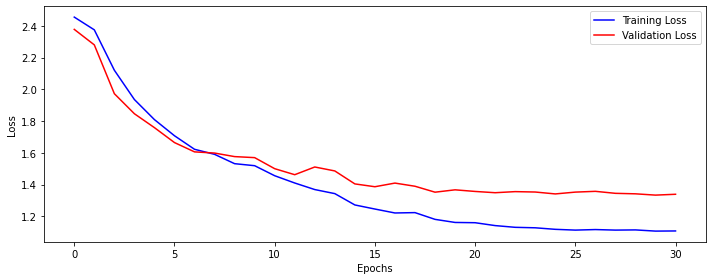

In [15]:
sbs = StepByStep(model, loss_fn, optimizer, scheduler)

sbs.set_loaders(train_loader, val_loader)
sbs.train_by_loss_change(1e-3)

sbs.plot_losses(ylog=False)

## 4. Test
### 4.1 Accuracy

In [20]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

x_test, y_test = list(test_loader)[0]
model.eval()
acc = (model(x_test).argmax(dim=1) == y_test).sum() / x_test.shape[0]
print("Accuracy:",  acc.item())

Accuracy: 0.6771084070205688


### 4.2 Confusion Matrix

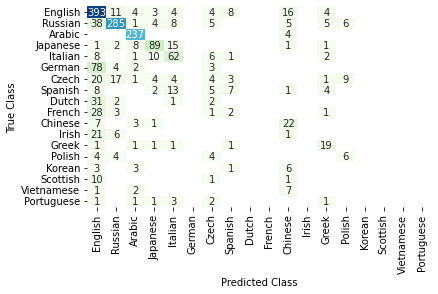

In [21]:
model.eval()

y_pred = F.softmax(model(x_test), dim=1).argmax(dim=1)

labels = list(nationality_vocab)

confusion = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(confusion, index=labels, columns=labels)
#conf_df[conf_df==0] = ""

sns.heatmap(conf_df, annot=True, cbar=None, cmap="GnBu", fmt="d", mask=conf_df==0)
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()
#confusion_matrix(y_test, y_pred)

### 4.3 Inference

In [22]:
def predict_nationality(surname, model, surname_vocab, nationality_vocab):
    model.eval()
    x = vectorize(surname, surname_vocab, max_surname_size)
    y_pred = model(x.unsqueeze(0))
    i = y_pred.argmax(dim=1).item()
    nationality = nationality_vocab.inverse[i]
    return nationality

predict_nationality("Trump", model, surname_vocab, nationality_vocab)

'English'

### 4.4 Top-K Inference

In [23]:
def predict_topk_nationality(surname, model, surname_vocab, nationality_vocab, k=5):
    model.eval()
    x = vectorize(surname, surname_vocab, max_surname_size)
    
    y_hat = model(x.unsqueeze(0))
    y_pred = F.softmax(y_hat, dim=1)

    probs, indices = torch.topk(y_pred, k=k)

    probs = probs.squeeze().tolist()
    indices = indices.squeeze().tolist()

    nationalities = {}
    print(f"Top {k} predictions:")
    for i, p in zip(indices, probs):
        nationality = nationality_vocab.inverse[i]
        nationalities[nationality] = p
        print(f"{surname} => {nationality} (p={p:.3f})")


predict_topk_nationality("Trump", model, surname_vocab, nationality_vocab, k=5)

Top 5 predictions:
Trump => English (p=0.617)
Trump => German (p=0.109)
Trump => Irish (p=0.071)
Trump => Scottish (p=0.043)
Trump => Dutch (p=0.040)
